In [1]:
from __future__ import print_function
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import argparse
import unet2d
import augmentor2d
import pandas as pd

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--input_dir', type=str, default='/raid/COVID-19/CT-severity/processed/dataset/medseg_1/npzs/')
parser.add_argument('--test', type=int, nargs='+', default=[0])
parser.add_argument('--check_dir', type=str, default='/raid/COVID-19/CT-severity/results/Iran-2020-04-01-with-annotation/unet2d_256x256x7_mask/segmentation/focal_0_area_0/')

parser.add_argument('--device', type=str, default='2')
parser.add_argument('--batch_size', type=int, default=16)
parser.add_argument('--epoch', type=int, default=199)

net = unet2d.unet2d()
parser = net.add_to_parser(parser)

In [5]:
if sys.argv[0] != 'test_segmentation.py':
    args = parser.parse_args(['--device', '1', '--epoch', '199'])
else:
    args = parser.parse_args()

for k in vars(args):
    print (k, '=', vars(args)[k])

layers = 5
fc_nodes = [1024]
check_dir = /raid/COVID-19/CT-severity/results/Iran-2020-04-01-with-annotation/unet2d_256x256x7_mask/segmentation/focal_0_area_0/
up_layers = 0
input_dir = /raid/COVID-19/CT-severity/processed/dataset/medseg_1/npzs/
keep_prob = 1.0
n_class = 6
dice_smooth = 1
batch_size = 16
input_shape = [256, 256, 7]
device = 1
epoch = 199
test = [0]
filter_size = 3
pool_size = 2
fc_drop = [0.25]
features_root = 32
finetune_scope = finetune


In [6]:
# build network
os.environ['CUDA_VISIBLE_DEVICES'] = args.device
tf.reset_default_graph()
model = unet2d.unet2d()
model.from_args(args)
model.build_unet()

loader = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
try:
#     loader.restore(sess, '../UNet2D-Kuang/result_dice_focal/V0zteandmriRigid_Beta0it100')
    loader.restore(sess, os.path.join(args.check_dir, str(args.epoch)))
except Exception as e:
    print ('Failed to restore from checkpoint:', e)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /raid/COVID-19/CT-severity/results/Iran-2020-04-01-with-annotation/unet2d_256x256x7_mask/segmentation/focal_0_area_0/199


In [7]:
# load training data
list_filename = [os.path.join(args.input_dir, str(s)+'.npz') for s in args.test]
imgs = []
labels = []
mrns = []
lungs = []
islices = []
annotations = []
for filename in list_filename:
    dataset = os.path.basename(filename)[:-len('.npz')]
    f = np.load(filename)
    imgs.append(f['img'])
    labels.append(f['label'])
    mrns.append(f['mrn'])
    lungs.append(f['lung'])
    islices.append(f['islice'])
    annotations.append(f['annotation'])


# imgs = np.concatenate(imgs)
# labels = np.concatenate(labels)
# mrns = np.concatenate(mrns)
# lungs = np.concatenate(lungs)

# discard the ones with non-determined labels
# sum_label = labels.sum(-1)
# inds = np.where(sum_label >= 0)[0]
# imgs = imgs[inds, ...]
# labels = labels[inds, ...]
# mrns = mrns[inds, ...]

In [9]:
labels[0].shape

(407, 256, 256, 1)

In [10]:
np.unique(labels[0])

array([0., 1., 2.], dtype=float32)

In [7]:
# output to another set of file with the predicted volumes
# the predicted volumes will be used to train type classification
output_dir = os.path.join(args.input_dir, 'with_unet_pred')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for i, filename in enumerate(list_filename):
    print (i)
    preds = []
    for ibatch in range(0, imgs[i].shape[0], args.batch_size):
        print ('%d/%d'%(ibatch, imgs[i].shape[0]), end=',')
        batch_x = imgs[i][ibatch:ibatch + args.batch_size]
        pred = sess.run(model.pred, {model.X: batch_x, model.phase: 0})

        preds.append(pred)
    preds = np.concatenate(preds)
    
    np.savez(os.path.join(output_dir, os.path.basename(filename)), 
             pred = preds, img = imgs[i], label = labels[i], annotation = annotations[i], 
             lung = lungs[i], mrns = mrns[i], islice = islices[i])

0
0/407,16/407,32/407,48/407,64/407,80/407,96/407,112/407,128/407,144/407,160/407,176/407,192/407,208/407,224/407,240/407,256/407,272/407,288/407,304/407,320/407,336/407,352/407,368/407,384/407,400/407,

In [8]:
preds = []
for ibatch in range(0, imgs.shape[0], args.batch_size):
    print ('%d/%d'%(ibatch, imgs.shape[0]), end=',')
    batch_x = imgs[ibatch:ibatch + args.batch_size]
    pred = sess.run(model.pred, {model.X: batch_x, model.phase: 0})
    
    preds.append(pred)
preds = np.concatenate(preds)

0/688,16/688,32/688,48/688,64/688,80/688,96/688,112/688,128/688,144/688,160/688,176/688,192/688,208/688,224/688,240/688,256/688,272/688,288/688,304/688,320/688,336/688,352/688,368/688,384/688,400/688,416/688,432/688,448/688,464/688,480/688,496/688,512/688,528/688,544/688,560/688,576/688,592/688,608/688,624/688,640/688,656/688,672/688,

In [9]:
binary_preds = np.where(preds > 0.5, 1, 0)
dice = 2 * np.sum(labels * binary_preds) / (np.sum(labels) + np.sum(binary_preds))
print (dice)

0.7099983927547152


In [10]:
patient_mrns = np.unique(mrns)
label_sev = []
pred_sev = []
for mrn in patient_mrns:
    inds = np.where(mrns == mrn)[0]
    sub_img = imgs[inds, ..., 3]
    sub_label = labels[inds]
    sub_pred = preds[inds]
    sub_lung = lungs[inds]
    
    label_sev.append(np.sum(sub_label) / np.sum(sub_lung))
    pred_sev.append(np.sum(sub_pred) / np.sum(sub_lung))

(0, 1)

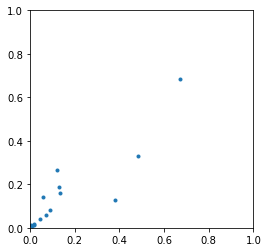

In [11]:
plt.figure(figsize=[4,4])
plt.plot(np.array(pred_sev), label_sev, '.')
plt.xlim([0,1])
plt.ylim([0,1])

In [12]:
import itertools

# classification accuracy
def get_discrete_severity(severity, thresholds):
    thresholds = np.sort(thresholds)
    label = np.zeros_like(severity)
    label[severity > thresholds[-1]] = len(thresholds)
    for k in range(len(thresholds)-1, -1, -1):
        label[severity <= thresholds[k]] = k
    return label.astype(int)

# confusion matrix
# confusion matrix
def CalcConfusionMatrix2(labels, preds, nClasses = 5):
    cm = np.zeros([nClasses, nClasses], int)
    
    for i in range(labels.shape[0]):
        cm[preds[i], labels[i]] += 1
    
    return cm

def plot_confusion_matrix(cm, class_names, title = 'Confusion matrix', 
                          ylabel = 'Prediction', xlabel = 'Label', normalized = True,
                          figsize = (6,6), dpi=200):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    if normalized:
        cm = np.around(cm.astype('float') / cm.sum(), decimals=2)
#     cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

#     plt.tight_layout()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    return figure

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = imageio.imread(buf)
    # Add the batch dimension
    
    return image[np.newaxis, ...]

0.8571428571428571


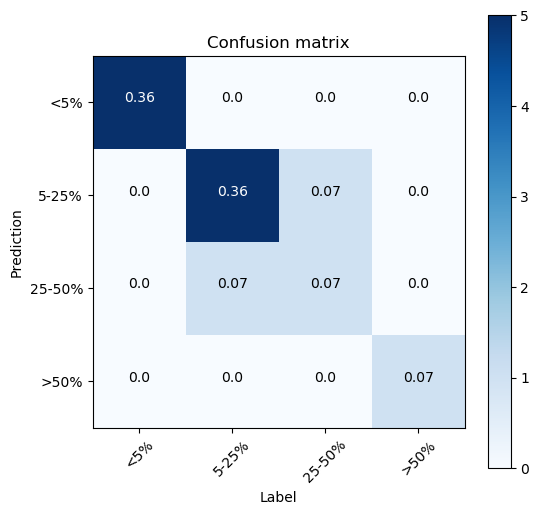

In [13]:
thresholds = [0.05, 0.25, 0.5]
discrete_label = get_discrete_severity(label_sev, thresholds)
discrete_pred = get_discrete_severity(pred_sev, thresholds)
cm = CalcConfusionMatrix2(discrete_label, discrete_pred, len(thresholds) + 1)
accuracy = np.sum(np.diag(cm)) / np.sum(cm, dtype=np.float32)
print (accuracy)
cm_img = plot_confusion_matrix(cm, ['<5%', '5-25%', '25-50%', '>50%'], normalized =True, dpi=100)